In [237]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [238]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [239]:
data = pd.read_csv("/content/drive/MyDrive/itmo/numeric_methods_of_analysis/lab_1/housing.csv")
X = data.drop('MEDV', axis=1)
Y = data['MEDV']
data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0


In [240]:
test_size = 0.21
random_state = 49
scale = StandardScaler()

In [241]:
def run_exp(degree, use_scaler, plot=False, robot=False):
    # Создаем полиномиальные признаки
    poly = PolynomialFeatures(degree=degree, include_bias=False, interaction_only=True)

    if robot:
        # Рзбиение данных на тренировочные и тестовые
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)

        if use_scaler:
            X_train = scale.fit_transform(X_train)
            X_test = scale.transform(X_test)

        # Вычисление коэффициентов и применение настроек на данных
        X_train = poly.fit_transform(X_train)
        X_test = poly.transform(X_test)

        # Создаем объект класса и вычисляем коэффициенты на Train
        model = LinearRegression(fit_intercept=True)
        model.fit(X_train, Y_train)

        # Предиктим
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)

    else:
        # Создаем полиномиальные признаки
        X_poly = poly.fit_transform(X)

        # Разделение данных на тестовые и обучающие
        X_train, X_test, Y_train, Y_test = train_test_split(X_poly, Y, test_size=test_size, random_state=random_state)

        # Инициализация скейлеров
        x_scaler, y_scaler = None, None

        # Масштабирование данных
        if use_scaler:
            X_train = scale.fit_transform(X_train)
            X_test = scale.transform(X_test)

            Y_train = scale.fit_transform(Y_train.values.reshape(-1, 1)).flatten()

        # Находим число обусловленности и находим коэффициеты, решая систему
        XTX = X_train.T @ X_train
        cond_number = np.linalg.cond(XTX)
        try:
            theta = np.linalg.inv(XTX) @ X_train.T @ Y_train
        except np.linalg.LinAlgError:
            theta = np.linalg.pinv(XTX) @ X_train.T @ Y_train

        # Получение предсказаний
        train_pred = X_train @ theta
        test_pred = X_test @ theta

        # Обратное преобразование предсказаний (если скейлер True)
        if use_scaler:
            train_pred = scale.inverse_transform(train_pred.reshape(-1, 1)).flatten()
            test_pred = scale.inverse_transform(test_pred.reshape(-1, 1)).flatten()
            Y_train = scale.inverse_transform(Y_train.reshape(-1, 1)).flatten()

    # Расчет ошибок
    mae_train = mean_absolute_error(Y_train, train_pred)
    mae_test = mean_absolute_error(Y_test, test_pred)

    # Визуализация (если True)
    if plot:
        plt.figure(figsize=(15, 5))

        # График предсказаний против реальных значений
        plt.subplot(1, 2, 1)
        plt.scatter(Y_train, train_pred, alpha=0.3, label='Train')
        plt.scatter(Y_test, test_pred, alpha=0.3, label='Test')
        plt.plot([min(Y), max(Y)], [min(Y), max(Y)], 'r--')
        plt.xlabel('Реальные значения')
        plt.ylabel('Предсказания')
        plt.title(f'Way: {"Robot" if robot else "Analytics"}\nDegree {degree}, Scaler: {use_scaler}\nMAE Train: {mae_train:.2f}, Test: {mae_test:.2f}')
        plt.legend()

        # График ошибок
        plt.subplot(1, 2, 2)
        errors = np.concatenate([abs(train_pred - Y_train), abs(test_pred - Y_test)])
        plt.hist(errors, bins=30)
        plt.xlabel('Ошибка прогнозирования')
        plt.ylabel('Количество')
        plt.title('Распределение ошибок')
        plt.tight_layout()
        plt.show()

    if robot:
        return mae_train, mae_test
    else:
        return cond_number, mae_train, mae_test


In [242]:
# Функция для вывода таблицы результатов
def result(robobot=False):
  # Вывод таблицы с результатами "ручного" метода
  if not robobot:
    results = pd.DataFrame(columns=['Degree', 'Scaler', 'MAE Train', 'MAE Test', 'Condition Number'])
    for degree in [1, 2, 3]:
        for use_scaler in [False, True]:
            cond, mae_tr, mae_te = run_exp(degree=degree, use_scaler=use_scaler, robot=False)
            results.loc[len(results)] = {
                'Degree': degree,
                'Scaler': use_scaler,
                'Condition Number': cond,
                'MAE Train': mae_tr,
                'MAE Test': mae_te,
            }

    results = results.round({
        'MAE Train': 3,
        'MAE Test': 3,
    })

  # Вывод таблицы с результатами "машинного" метода
  else:
    results = pd.DataFrame(columns=['Degree', 'Scaler', 'MAE Train', 'MAE Test'])
    for degree in [1, 2, 3]:
        for use_scaler in [False, True]:
            mae_tr, mae_te = run_exp(degree=degree, use_scaler=use_scaler, robot=True)
            results.loc[len(results)] = {
                'Degree': degree,
                'Scaler': use_scaler,
                'MAE Train': mae_tr,
                'MAE Test': mae_te,
            }

    results = results.round({
        'MAE Train': 3,
        'MAE Test': 3,
    })
  return results

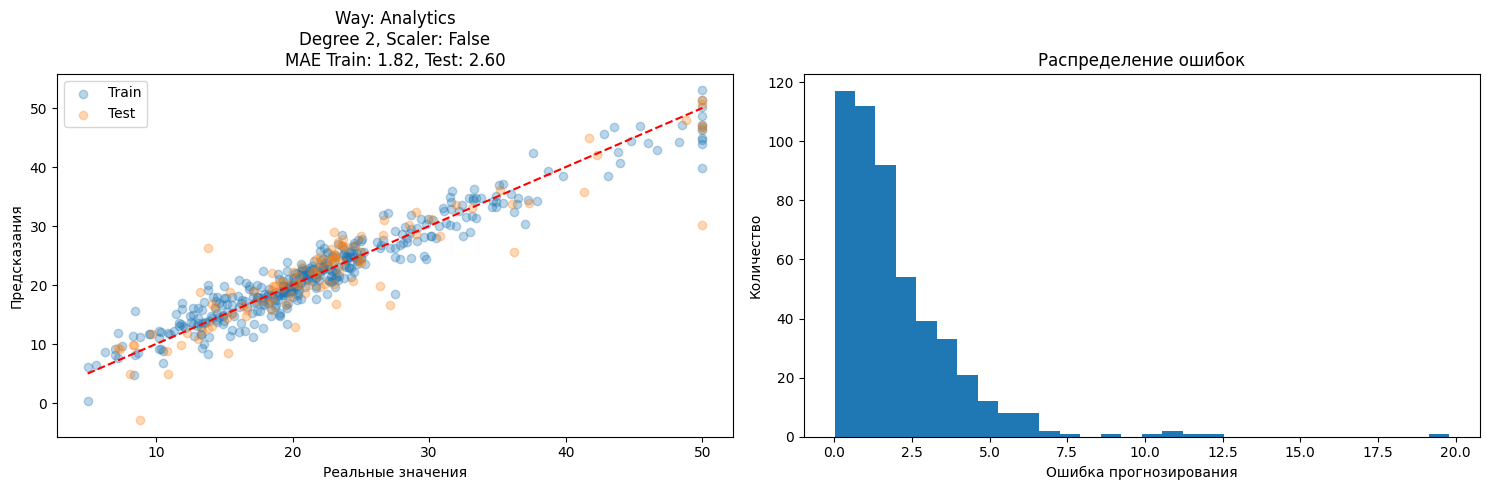

(np.float64(4512722826405441.0), 1.8175196072469928, 2.5988595470330225)

In [243]:
run_exp(degree=2, use_scaler=False, plot=True, robot=False)

In [244]:
res = result(robobot=False)
res

,Degree,Scaler,MAE Train,MAE Test,Condition Number
0,1,False,3.283,3.481,7.248816e+07
1,1,True,3.237,3.566,9.587028e+01
2,2,False,1.818,2.599,4.512723e+15
3,2,True,1.809,2.572,1.722967e+08
4,3,False,85.499,2899087.931,1.446579e+30
5,3,True,1.844,253.193,2.395357e+17


In [245]:
res = result(robobot=True)
res

,Degree,Scaler,MAE Train,MAE Test
0,1,False,3.237,3.566
1,1,True,3.237,3.566
2,2,False,1.809,2.572
3,2,True,1.809,2.572
4,3,False,0.645,10.403
5,3,True,0.645,32.570
